In [1]:
import numpy as np  # 线性代数
import pandas as pd  # 数据预处理, CSV 文件 I/O (e.g. pd.read_csv)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

2024-05-19 21:46:44.981684: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
data = pd.read_csv("fer2013.csv")
# 查看数据集形状
data.shape

(35887, 3)

In [3]:
#预览前10行数据
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [4]:
#查看数据集的分类情况
#80% 训练, 10% 验证 and 10% 测试
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [5]:
#查看表情分类数据
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts().sort_index().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Disgust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


Text(0.5, 0, 'Emotions')

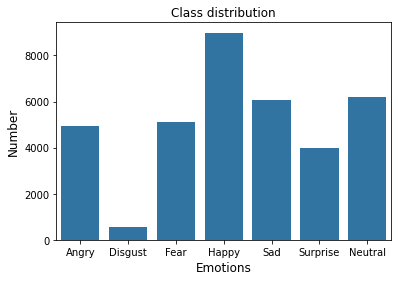

In [6]:
# 绘制类别分布条形图
plt.figure(figsize=(6, 4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
#plt.show()

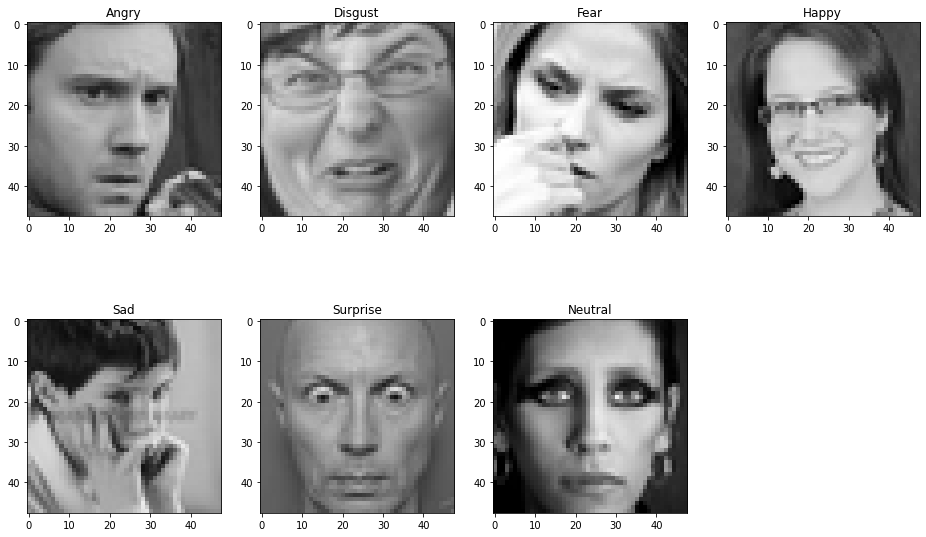

In [7]:
def row2image_label(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48, 48)
    image = np.zeros((48, 48, 3))
    image[:, :, 0] = img
    image[:, :, 1] = img
    image[:, :, 2] = img
    return image.astype(np.uint8), emotion

plt.figure(0, figsize=(16, 10))
for i in range(1, 8):
    face = data[data['emotion'] == i - 1].iloc[0]
    img, label = row2image_label(face)
    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.title(label)

plt.show()

In [8]:
#分割数据为: train, validation, test
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
print(f"train shape: {data_train.shape}")
print(f"validation shape: {data_val.shape}")
print(f"test shape: {data_test.shape}")

train shape: (28709, 3)
validation shape: (3589, 3)
test shape: (3589, 3)


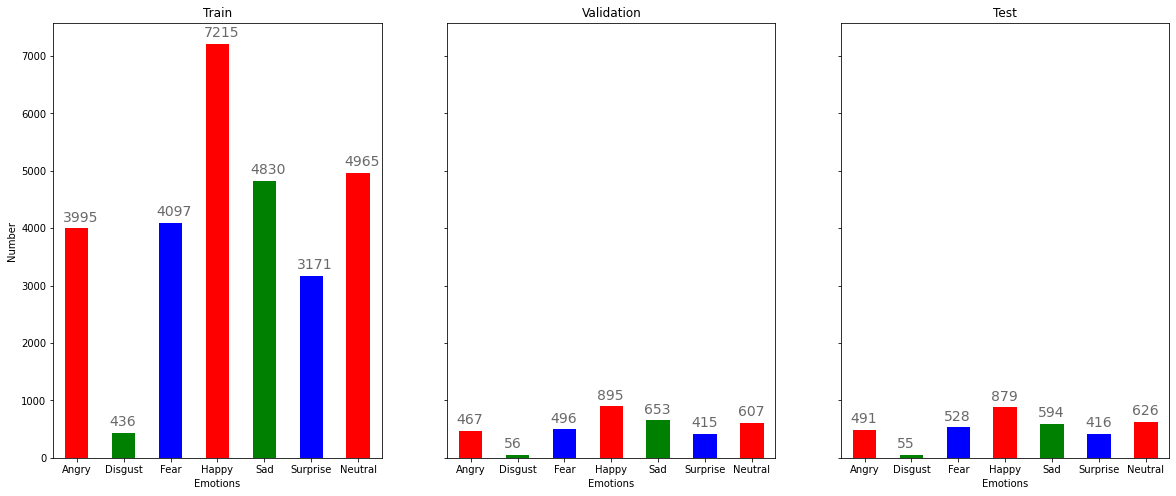

In [9]:
# 绘制train, val, test的条形图
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


def setup_axe(axe, df, title):
    df['emotion'].value_counts().sort_index().plot(ax=axe, kind='bar', rot=0,
                                                   color=['r', 'g', 'b', 'r', 'g', 'b', 'r'])
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)

    # 使用上述列表设置单个条形标签
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x() - .05, i.get_height() + 120,
                 str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                 rotation=0)

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey='all')
setup_axe(axes[0], data_train, 'Train')
setup_axe(axes[1], data_val, 'Validation')
setup_axe(axes[2], data_test, 'Test')
plt.show()

In [10]:
#初始化参数
num_classes = 7
width, height = 48, 48
num_epochs = 150
batch_size = 64
num_features = 64
rate_drop = 0.1

In [11]:
# 将数据标签由字符串改为整数
# 调整图片大小为 48x48, 归一化图像
# 更改标签编码为one-hot, e.g. 类别3(Happy)为 **[0,0,0,1,0,0,0]**

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1, width, height, 1) / 255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y


train_X, train_Y = CRNO(data_train, "train")  #training data
val_X, val_Y = CRNO(data_val, "val")  #validation data
test_X, test_Y = CRNO(data_test, "test")  #test data

train _X shape: (28709, 48, 48, 1),  train _Y shape: (28709, 7)
val _X shape: (3589, 48, 48, 1),  val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1),  test _Y shape: (3589, 7)


In [16]:
model = Sequential()

# ---------- Convolutional Stages 1 ----------
# ***** Conv Block a *****
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(width, height, 1),
                 data_format='channels_last', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---------- Convolutional Stages 2 ----------
# ***** Conv Block a *****
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---------- Convolutional Stages 3 ----------
# ***** Conv Block a *****
model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---------- Convolutional Stages 4 ----------
# ***** Conv Block a *****
model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# ***** Conv Block b *****
model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Full connection
model.add(Dense(4096, activation='relu', kernel_regularizer=l2()))
model.add(Dropout(rate_drop))
model.add(Dense(4096, activation='relu', kernel_regularizer=l2()))
model.add(Dropout(rate_drop))

#output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2()))

model.compile(loss=['categorical_crossentropy'],
              optimizer=SGD(momentum=0.9, nesterov=True ,decay=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_17 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 64)       

In [17]:
# 数据增强
data_generator = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=10,
    featurewise_std_normalization=False,
    horizontal_flip=True)

#过拟合监测，如果没有更小的验证损失，则网络停止训练
es = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
#学习速率监测，如果没有更好的验证精度，则降低学习速率
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75, patience=5, verbose=1)

history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                    # steps_per_epoch=len(train_X) / batch_size,
                    batch_size=batch_size,
                    epochs=num_epochs ,
                    verbose=2,
                    callbacks=[es, reduce_lr],
                    validation_data=(val_X, val_Y))

Epoch 1/150
449/449 - 8s - loss: 42.4867 - accuracy: 0.2535 - val_loss: 16.5153 - val_accuracy: 0.2497
Epoch 2/150
449/449 - 7s - loss: 8.7224 - accuracy: 0.2923 - val_loss: 4.4230 - val_accuracy: 0.2778
Epoch 3/150
449/449 - 7s - loss: 2.9610 - accuracy: 0.3320 - val_loss: 2.2842 - val_accuracy: 0.3318
Epoch 4/150
449/449 - 7s - loss: 1.7786 - accuracy: 0.4154 - val_loss: 1.5313 - val_accuracy: 0.4684
Epoch 5/150
449/449 - 7s - loss: 1.4738 - accuracy: 0.4677 - val_loss: 1.4101 - val_accuracy: 0.4745
Epoch 6/150
449/449 - 7s - loss: 1.3607 - accuracy: 0.5012 - val_loss: 1.3634 - val_accuracy: 0.5015
Epoch 7/150
449/449 - 7s - loss: 1.2899 - accuracy: 0.5281 - val_loss: 1.2989 - val_accuracy: 0.5302
Epoch 8/150
449/449 - 7s - loss: 1.2553 - accuracy: 0.5398 - val_loss: 1.3726 - val_accuracy: 0.5077
Epoch 9/150
449/449 - 7s - loss: 1.2140 - accuracy: 0.5616 - val_loss: 1.5120 - val_accuracy: 0.4795
Epoch 10/150
449/449 - 7s - loss: 1.1879 - accuracy: 0.5673 - val_loss: 1.4272 - val_accu

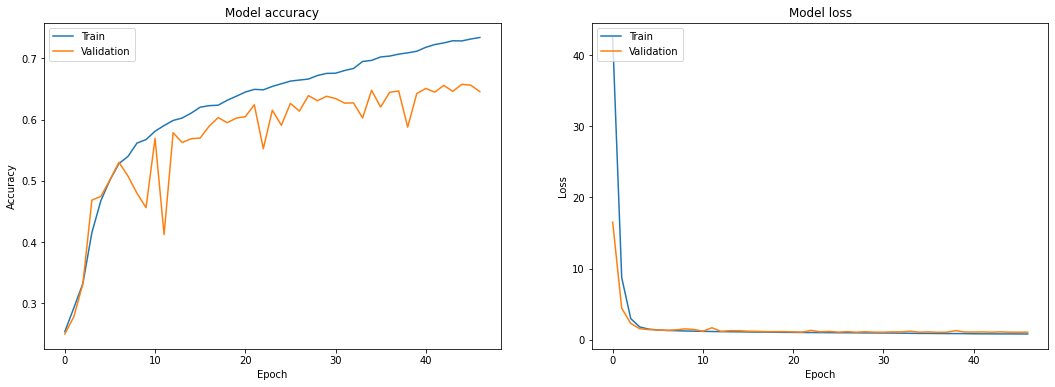

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# 绘制训练和验证精度曲线
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# 绘制训练和验证损失曲线
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

Model Accuracy on test set: 0.6656


In [20]:
 model.save("autodl-tmp/models/VGG/VGGNet.h5")